<a href="https://colab.research.google.com/github/jamestheengineer/data-science-from-scratch-Python/blob/master/Chapter_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Only do this once per VM, otherwise you'll get multiple clones and nested directories
!git clone https://github.com/jamestheengineer/data-science-from-scratch-Python.git
%cd data-science-from-scratch-Python/
!pip install import-ipynb
import import_ipynb

Cloning into 'data-science-from-scratch-Python'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 429 (delta 25), reused 0 (delta 0), pack-reused 387
Receiving objects: 100% (429/429), 1.07 MiB | 1.21 MiB/s, done.
Resolving deltas: 100% (265/265), done.
/content/data-science-from-scratch-Python
  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp36-none-any.whl size=2976 sha256=9aef5b1a14c7b4f0a05214e9293aa1989bcaca6acc1a8ffb50e08c262fa6c0b5
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb


In [2]:
# Deep learning chapter

Tensor = list

from typing import List

def shape(tensor: Tensor) -> List[int]:
  sizes: List[int] = []
  while isinstance(tensor, list):
    sizes.append(len(tensor))
    tensor = tensor[0]
  return sizes

assert shape([1, 2, 3]) == [3]
assert shape([[1, 2], [3, 4], [5, 6]]) == [3, 2]


In [3]:
def is_1d(tensor: Tensor) -> bool:
  """
  If tensor[0] is a list, it's a higher-order tensor.
  Otherwise, tensor is 1-dimensional (that is, a vector)
  """
  return not isinstance(tensor[0], list)

assert is_1d([1,2,3])
assert not is_1d([[1,2],[3,4]])

In [4]:
def tensor_sum(tensor: Tensor) -> float:
  """Sums up all the values in the tensor"""
  if is_1d(tensor):
    return sum(tensor) # just a list of floats, use Python sum
  else:
    return sum(tensor_sum(tensor_i) # Call tensor_sum on each row
               for tensor_i in tensor) # and sum up those results

assert tensor_sum([1,2,3]) == 6
assert tensor_sum([[1,2],[3,4]]) == 10

In [5]:
from typing import Callable

def tensor_apply(f: Callable[[float], float], tensor: Tensor) -> Tensor:
  """Applies f elementwise"""
  if is_1d(tensor):
    return [f(x) for x in tensor]
  else:
    return [tensor_apply(f, tensor_i) for tensor_i in tensor]

assert tensor_apply(lambda x: x+1, [1, 2, 3]) == [2,3,4]
assert tensor_apply(lambda x: 2 * x, [[1,2],[3,4]]) == [[2,4],[6,8]]

In [6]:
def zeros_like(tensor: Tensor) -> Tensor:
  return tensor_apply(lambda _: 0.0, tensor)

assert zeros_like([1,2,3]) == [0,0,0]
assert zeros_like([[1,2],[3,4]]) == [[0,0],[0,0]]

In [7]:
def tensor_combine(f: Callable[[float, float], float],
                   t1: Tensor,
                   t2: Tensor) -> Tensor:
    """Applies f to corresponding elements of t1 and t2"""
    if is_1d(t1):
      return [f(x,y) for x, y in zip(t1,t2)]
    else:
      return [tensor_combine(f, t1_i, t2_i)
              for t1_i, t2_i in zip(t1, t2)]

import operator

assert tensor_combine(operator.add, [1,2,3],[4,5,6]) == [5,7,9]
assert tensor_combine(operator.mul, [1,2,3], [4,5,6]) == [4,10,18]

In [8]:
from typing import Iterable, Tuple

class Layer:
  """
  Our neural networks will be composed of layers, each of which
  knows how to do some computation on its inputs in the "forward"
  direction and propagate gradients in the "backward" direction.
  """
  def backward(self, gradient):
    """
    Similarly, we're not going to be prescriptive about what the
    gradient looks like. It's up to you the user to make sure 
    that you're doing things sensibly.
    """
    raise NotImplementedError
  
  def params(self) -> Iterable[Tensor]:
    """
    Returns the parameters of this layer. The default implementation 
    returns nothing, so that if you have a layer with no parameters
    you don't have to implement this.
    """
    return ()

  def grads(self) -> Iterable[Tensor]:
    """
    Returns the gradients, in the smae order as params().
    """
    return ()

In [9]:
from Chapter_18 import sigmoid

class Sigmoid(Layer):
  def forward(self, input: Tensor) -> Tensor:
    """
    Apply sigmoid to each element of the input tensor,
    and save the results to use in backpropagation.
    """
    self.sigmoids = tensor_apply(sigmoid, input)
    return self.sigmoids

  def backward(self, gradient: Tensor) -> Tensor:
    return tensor_combine(lambda sig, grad: sig * (1 - sig) * grad,
                          self.sigmoids,
                          gradient)

importing Jupyter notebook from Chapter_18.ipynb
importing Jupyter notebook from Chapter_04.ipynb
1 1 1
1 / 100
2 2 2
2 / 100
3 3 fizz
2 / 100
4 fizzbuzz 4
2 / 100
5 5 buzz
2 / 100
6 fizzbuzz fizz
2 / 100
7 7 7
3 / 100
8 buzz 8
3 / 100
9 buzz fizz
3 / 100
10 10 buzz
3 / 100
11 buzz 11
3 / 100
12 fizzbuzz fizz
3 / 100
13 13 13
4 / 100
14 14 14
5 / 100
15 15 fizzbuzz
5 / 100
16 16 16
6 / 100
17 17 17
7 / 100
18 18 fizz
7 / 100
19 19 19
8 / 100
20 20 buzz
8 / 100
21 21 fizz
8 / 100
22 22 22
9 / 100
23 23 23
10 / 100
24 24 fizz
10 / 100
25 25 buzz
10 / 100
26 26 26
11 / 100
27 27 fizz
11 / 100
28 28 28
12 / 100
29 29 29
13 / 100
30 30 fizzbuzz
13 / 100
31 31 31
14 / 100
32 32 32
15 / 100
33 33 fizz
15 / 100
34 34 34
16 / 100
35 35 buzz
16 / 100
36 36 fizz
16 / 100
37 37 37
17 / 100
38 38 38
18 / 100
39 39 fizz
18 / 100
40 40 buzz
18 / 100
41 41 41
19 / 100
42 42 fizz
19 / 100
43 43 43
20 / 100
44 44 44
21 / 100
45 45 fizzbuzz
21 / 100
46 46 46
22 / 100
47 47 47
23 / 100
48 48 fizz
23 / 100

importing Jupyter notebook from Chapter_06.ipynb
P(both | older): 0.5007089325501317
P(both | either): 0.3311897106109325


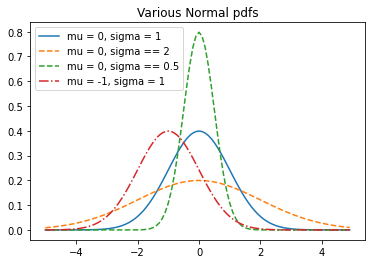

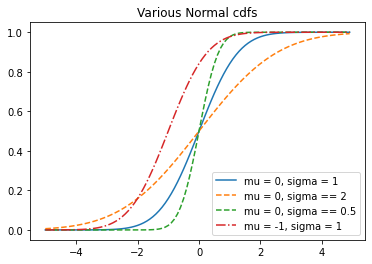

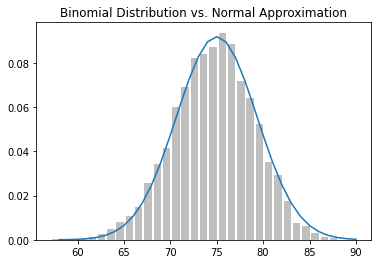

In [10]:
# Functions to randomly generate our weight tensors
import random

from Chapter_06 import inverse_normal_cdf

def random_uniform(*dims: int) -> Tensor:
  if len(dims) == 1:
    return [random.random() for _ in range(dims[0])]
  else:
    return [random_uniform(*dims[1:]) for _ in range(dims[0])]

def random_normal(*dims: int,
                  mean: float = 1.0,
                  variance: float = 1.0) -> Tensor:
  if len(dims) == 1:
    return [mean + variance * inverse_normal_cdf(random.random())
            for _ in range(dims[0])]
  else:
    return [random_normal(*dims[1:], mean=mean, variance=variance)
            for _ in range(dims[0])]

assert shape(random_uniform(2,3,4)) == [2,3,4]
assert shape(random_normal(5,6,mean=10)) == [5,6]

In [11]:
# Wrap them all in a random_tensor function

def random_tensor(*dims: int, init: str = 'normal') -> Tensor:
  if init == 'normal':
    return random_normal(*dims)
  elif init == 'uniform':
    return random_uniform(*dims)
  elif init == 'xavier':
    variance = len(dims) / sum(dims)
    return random_normal(*dims, variance=variance)
  else:
    raise ValueError(f"unknown init: {init}")

In [12]:
# Define the linear layer
from Chapter_04 import dot

class Linear(Layer):
  def __init__(self,
               input_dim: int,
               output_dim: int,
               init: str = 'xavier') -> None:
    """
    A layer of output_dim neurons, each with input_dim weights
    (and a bias)
    """
    self.input_dim = input_dim
    self.output_dim = output_dim

    # self.w[o] is the weights for the oth neuron
    self.w = random_tensor(output_dim, input_dim, init=init)

    # self.b[o] is the bias term for the oth neuron
    self.b = random_tensor(output_dim, init=init)

  def forward(self, input: Tensor) -> Tensor:
    # Save the input to use in the backward pass.
    self.input = input
    # Return the vector of neuron outputs.
    return [dot(input, self.w[o]) + self.b[o]
            for o in range(self.output_dim)]
  
  def backward(self, gradient: Tensor) -> Tensor:
    # Each b[o] gets added to output[o], which means
    # the gradient of b is the same as the output gradient.
    self.b_grad = gradient

    # Each w[o][i] multiples input[i] and gets added to outpu[o].
    # So its gradient is input[i] * gradient[o].
    self.w_grad = [[self.input[i] * gradient[o]
                    for i in range(self.input_dim)]
                   for o in range(self.output_dim)]
    
    # Each input[i] multiplies every w[o][i] and gets added to every
    # output[o]. So its gradien is the sum of w[o][i] * gradient[o]
    # across all the outputs.
    return [sum(self.w[o][i] * gradient[o] for o in range(self.output_dim))
            for i in range(self.input_dim)]

  def params(self) -> Iterable[Tensor]:
    return [self.w, self.b]

  def grads(self) -> Iterable[Tensor]:
    return [self.w_grad, self.b_grad]

In [13]:
from Chapter_18 import sigmoid

class Sigmoid(Layer):
  def forward(self, input: Tensor) -> Tensor:
    """
    Apply sigmoid to each element of the input tensor,
    and save the results to use in backpropagation.
    """
    self.sigmoids = tensor_apply(sigmoid, input)
    return self.sigmoids

  def backward(self, gradient: Tensor) -> Tensor:
    return tensor_combine(lambda sig, grad: sig * (1 - sig) * grad,
                          self.sigmoids,
                          gradient)